In [ ]:
!pip install nltk numpy openpyxl Pillow pyparsing scikit-learn scipy tqdm keras scipy tensorflow transformers tensorflow-text tf-models-official

     |████████████████████████████████| 2.1MB 11.7MB/s 
     |████████████████████████████████| 3.4MB 42.4MB/s 
     |████████████████████████████████| 1.1MB 70.3MB/s 
     |████████████████████████████████| 901kB 68.0MB/s 
     |████████████████████████████████| 3.3MB 49.1MB/s 
     |████████████████████████████████| 37.6MB 90kB/s 
     |████████████████████████████████| 174kB 74.4MB/s 
     |████████████████████████████████| 102kB 8.0MB/s 
     |████████████████████████████████| 706kB 60.6MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 358kB 66.1MB/s 
     |████████████████████████████████| 1.2MB 55.0MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-cp37-none-any.whl size=22245 sha256=f64d17b2f2aa9c25ea7d830fb0385c2e122e15f2524a6925712b263a02898df4
  Stored in directory: /root/.cache/pip/wheels/2e/15/f5/aa2a056d223903b52cf4870134e3a01df0c723816835dd08db
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.

In [ ]:
import nltk
import re
from openpyxl import load_workbook
from sklearn import preprocessing
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import numpy as np
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers
# K Fold validation with the model
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score
from keras.utils import to_categorical
from transformers import BertTokenizer, TFBertModel, TFBertPreTrainedModel, TFBertMainLayer, TFBertForSequenceClassification


nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

In [ ]:
contractions = [
    (r"won\'t", "will not"),
    (r"can\'t", "cannot"),
    (r"i\'m", "i am"),
    (r"ain\'t", "is not"),
    (r"(\w+)\'ll", "\g<1> will"),
    (r"(\w+)n\'t", "\g<1> not"),
    (r"(\w+)\'ve", "\g<1> have"),
    (r"(\w+)\'s", "\g<1> is"),
    (r"(\w+)\'re", "\g<1> are"),
    (r"(\w+)\'d", "\g<1> would")
]


class Expander(object):
    def __init__(self, patterns=contractions):
        self.patterns = [(re.compile(regex, re.IGNORECASE), repl) for (regex, repl) in patterns]

    def expand(self, text):
        s = text
        for (pattern, repl) in self.patterns:
            s = re.sub(pattern, repl, s)
        return s

In [ ]:
ALL_CLASSES = [
    "content discussion", "greeting", "logistics", "assignment instructions", "instruction question",
    "assignment question", "general comment", "response", "incomplete/typo", "feedback",
    "emoticon/non-verbal", "discussion wrap-up", "outside material", "opening statement",
    "general question", "content question", "general discussion"
]
DATASET_PATH = "data/dataset.xlsx"

# Opens a single sheet for reading, returns a list of messages and a list of classes
def read_worksheet(filename, sheet_name, all_classes, label_encoder, no_columns):
    wb = load_workbook(filename, read_only=True)
    ws = wb[sheet_name]
    column_labels = next(ws.rows)
    X = []
    y = []
    for row in ws.rows:
        if row[0].value is None:
            break
        elif row[0].value.strip() == "Course":  # Skip the first line which only contains column titles
            continue
        new_entry = {}
        for i in range(no_columns):
            new_entry[column_labels[i].value.lower().replace(" ", "_")] = str(row[i].value)
        c_list = [new_entry["codepreliminary"].lower().strip()]
        if c_list[0] not in all_classes:
            c_list = new_entry["codepreliminary"].lower().strip().split("/")
        # If there are 2 classes listed in document add message twice (1 for each class)
        for c in c_list:
            new_entry["codepreliminary"] = label_encoder.transform([c])[0]
            X.append(new_entry["message"])
            y.append(label_encoder.transform([c])[0])
    wb.close()
    return X, y

le = preprocessing.LabelEncoder()
le.fit(ALL_CLASSES)

LabelEncoder()

In [ ]:
def preprocess_data(dataset, classes):
    # List of emojis found in messages
    emojis = [":)", ":(", ":D", "👍"]
    ps = PorterStemmer()
    tkn = TweetTokenizer()  # Use tweet tokenizer to not split emojis as punctuation
    exp = Expander()  # Expands contractions such as I'm, he's into I am, he is
    new_dataset = []
    new_classes = []
    stopword_set = stopwords.words("english")
    for i, entry in enumerate(dataset):
        exp.expand(entry)
        new_entry = []
        # Remove capitalization, stopwords
        for token in tkn.tokenize(entry):
            new_token = ps.stem(token)  # Stem the token and convert to lowercase
            if new_token.startswith("http"):
                new_token = "url"  # Replace links with a url tag
            if any(emoji in new_token for emoji in emojis):
                new_token = "emoji"  # Replace emojis with a string
            if (new_token not in stopword_set or len(new_token) == 1) and new_token.isalnum():
                new_entry.append(new_token)
        if len(new_entry) > 0:
            new_dataset.append(" ".join(new_entry))
            new_classes.append(classes[i])

    return new_dataset, new_classes

In [ ]:
X, y = read_worksheet(DATASET_PATH, "Discussion only data", ALL_CLASSES, le, 10)
X2, y2 = read_worksheet(DATASET_PATH, "CREW data", ALL_CLASSES, le, 11)
X.extend(X2)  # Join worksheets into a single dataset
y.extend(y2)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
random_seed = 99
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

train_data = tf.data.Dataset.from_tensor_slices((tf.constant(X_train), tf.constant(y_train))).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((tf.constant(X_test), tf.constant(y_test))).batch(batch_size)

In [ ]:
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessing")
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1", name="Bert_encoder")

In [ ]:
def build_classifier_model(preprocess_model, bert_model, no_classes):
  text_input = layers.Input(shape=(), dtype=tf.string, name="text")
  preprocessing_layer = preprocess_model
  encoder_inputs = preprocessing_layer(text_input)
  encoder = bert_model
  outputs = encoder(encoder_inputs)
  net = outputs["pooled_output"]
  net = layers.Dropout(0.1)(net)
  net = layers.Dense(no_classes, activation="relu", name="classifier")(net)
  return tf.keras.Model(text_input, net)

In [ ]:
model = build_classifier_model(bert_preprocess_model, bert_model, len(ALL_CLASSES))
#tf.keras.utils.plot_model(model)
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
optimizer = optimization.create_optimizer(init_lr=3e-5,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=metric)

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


In [ ]:
history = model.fit(x=train_data, epochs=epochs)

Epoch 1/5
 3/22 [===>..........................] - ETA: 33s - loss: 9.6475 - accuracy: 0.0642

KeyboardInterrupt: ignored

dict_keys(['loss', 'accuracy'])


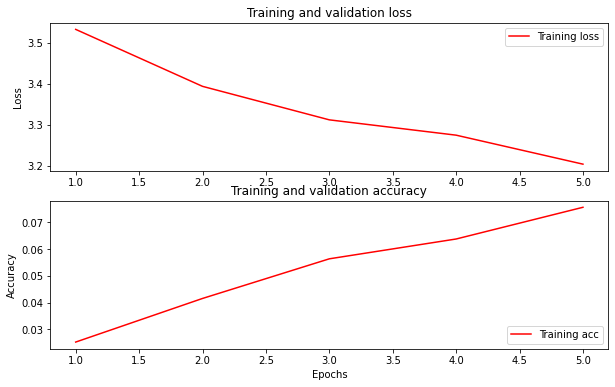

In [ ]:
# Plot history
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
class CustomModel(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="custom_test_model"):
        super(CustomModel, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [ ]:
class BertCustomModel(TFBertPreTrainedModel):
    
    def __init__(self, config,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="custem_bert_model", *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        
        self.bert = TFBertMainLayer(config, name="bert", trainable = False)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                kernel_size=2,
                                padding="valid",
                                activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units=256, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training=False, **kwargs):
        bert = self.bert(inputs, training=training, **kwargs)
        l = self.cnn_layer1(bert[0])
        l = self.pool(l)
        l = self.dense_1(l)
        l = self.dropout(l, training)
        model_output = self.last_dense(l) 
        
        return model_output

In [ ]:
class BertCustomModel2(TFBertPreTrainedModel):
    
    def __init__(self, config,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="custem_bert_model2", *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        self.bert = TFBertMainLayer(config, name="bert", trainable = False)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training=False, **kwargs):
        bert = self.bert(inputs, training=training, **kwargs)
        l_1 = self.cnn_layer1(bert[0]) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(bert[0]) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(bert[0])
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [ ]:
no_folds = 5
kfold = KFold(no_folds, shuffle=True)

# Convert to numpy arrays so indexing with list of indexes works
X = np.array(X) 
y = np.array(y)

test_accuracy_log = []

for train, test in kfold.split(X, y):
  X_train = X[train]
  X_train, vocab_len = BertTokenize(X_train)
  y_train = y[train]
  X_test = X[test]
  X_test, _ = BertTokenize(X_test)
  y_test = y[test]
  #y_train = to_categorical(y_train, OUTPUT_CLASSES)
  #y_test = to_categorical(y_test, OUTPUT_CLASSES)

  custom_model = BertCustomModel2.from_pretrained('bert-base-uncased',
                      cnn_filters=CNN_FILTERS,
                      dnn_units=DNN_UNITS,
                      model_output_classes=OUTPUT_CLASSES,
                      dropout_rate=DROPOUT_RATE)

  optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

  custom_model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

  train_data = tf.data.Dataset.from_tensor_slices((tf.constant(X_train), tf.constant(y_train))).batch(12)
  test_data = tf.data.Dataset.from_tensor_slices((tf.constant(X_test), tf.constant(y_test))).batch(12)
  custom_model.fit(train_data, epochs=5)

  score = custom_model.evaluate(test_data)
  print("Results for fold\n\tTest accuracy: {:.4f}\n\tTest loss: {:.4f}".format(score[1], score[0]))
  test_accuracy_log.append(score[1])
  
print(f"Accuracy score: {sum(test_accuracy_log) / len(test_accuracy_log)}")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing BertCustomModel2: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing BertCustomModel2 from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertCustomModel2 from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of BertCustomModel2 were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dense_229', 'dense_228', 'dropout_780', 'conv1d_221', 'conv1d_220', 'conv1d_219', 'global_max_pooling1d_90']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
57/57 [==============================] - 635s 11s/step - loss: 4.0100 - accuracy: 0.1420
Epoch 2/5
57/57 [==============================] - 620s 11s/step - loss: 1.7110 - accuracy: 0.5633
Epoch 3/5
57/57 [==============================] - 620s 11s/step - loss: 1.5600 - accuracy: 0.5934
Epoch 4/5
57/57 [==============================] - 619s 11s/step - loss: 1.4514 - accuracy: 0.5952
Epoch 5/5
15/15 [==============================] - 136s 9s/step - loss: 1.7500 - accuracy: 0.4970
Results for fold
	Test accuracy: 0.4970
	Test loss: 1.7500


Some layers from the model checkpoint at bert-base-uncased were not used when initializing BertCustomModel2: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing BertCustomModel2 from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertCustomModel2 from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of BertCustomModel2 were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['conv1d_223', 'dropout_818', 'conv1d_222', 'dense_230', 'dense_231', 'conv1d_224', 'global_max_pooling1d_91']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
57/57 [==============================] - 634s 11s/step - loss: 3.2119 - accuracy: 0.1994
Epoch 2/5
57/57 [==============================] - 618s 11s/step - loss: 1.6469 - accuracy: 0.5926
Epoch 3/5
57/57 [==============================] - 620s 11s/step - loss: 1.4619 - accuracy: 0.6038
Epoch 4/5
57/57 [==============================] - 620s 11s/step - loss: 1.4158 - accuracy: 0.6107
Epoch 5/5
15/15 [==============================] - 136s 9s/step - loss: 1.8780 - accuracy: 0.4852
Results for fold
	Test accuracy: 0.4852
	Test loss: 1.8780


Some layers from the model checkpoint at bert-base-uncased were not used when initializing BertCustomModel2: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing BertCustomModel2 from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertCustomModel2 from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of BertCustomModel2 were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_856', 'dense_232', 'dense_233', 'conv1d_225', 'global_max_pooling1d_92', 'conv1d_226', 'conv1d_227']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
57/57 [==============================] - 636s 11s/step - loss: 2.7915 - accuracy: 0.2424
Epoch 2/5
57/57 [==============================] - 621s 11s/step - loss: 1.7342 - accuracy: 0.5378
Epoch 3/5
 8/57 [===>..........................] - ETA: 8:59 - loss: 1.2987 - accuracy: 0.6859

KeyboardInterrupt: ignored

In [ ]:
custom_model = BertCustomModel.from_pretrained('bert-base-uncased',
                      cnn_filters=CNN_FILTERS,
                      dnn_units=DNN_UNITS,
                      model_output_classes=OUTPUT_CLASSES,
                      dropout_rate=DROPOUT_RATE)
#run_and_evaluate_bert(custom_model, X, y)
custom_model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing BertCustomModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing BertCustomModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertCustomModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of BertCustomModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['conv1d_191', 'global_max_pooling1d_80', 'dense_209', 'dense_208', 'dropout_474']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "bert_custom_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
conv1d_191 (Conv1D)          multiple                  153700    
_________________________________________________________________
global_max_pooling1d_80 (Glo multiple                  0         
_________________________________________________________________
dense_208 (Dense)            multiple                  25856     
_________________________________________________________________
dropout_474 (Dropout)        multiple                  0         
_________________________________________________________________
dense_209 (Dense)            multiple                  4369      
Total params: 109,666,165
Trainable params: 183,925
Non-trainable params: 109,482,240
___________________________

In [ ]:
custom_model = BertCustomModel2.from_pretrained('bert-base-uncased',
                      cnn_filters=CNN_FILTERS,
                      dnn_units=DNN_UNITS,
                      model_output_classes=OUTPUT_CLASSES,
                      dropout_rate=DROPOUT_RATE)
run_and_evaluate_bert(custom_model, X, y, save_model=False)
#custom_model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing BertCustomModel2: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing BertCustomModel2 from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertCustomModel2 from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of BertCustomModel2 were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['conv1d_204', 'dense_218', 'global_max_pooling1d_85', 'conv1d_205', 'conv1d_206', 'dense_219', 'dropout_664']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
57/57 [==============================] - 631s 11s/step - loss: 2.5605 - accuracy: 0.3306
Epoch 2/5
57/57 [==============================] - 616s 11s/step - loss: 2.0371 - accuracy: 0.4975
Epoch 3/5
57/57 [==============================] - 617s 11s/step - loss: 1.9040 - accuracy: 0.5239
Epoch 4/5
57/57 [==============================] - 615s 11s/step - loss: 1.8619 - accuracy: 0.5118
Epoch 5/5
15/15 [==============================] - 135s 9s/step - loss: 2.0363 - accuracy: 0.4142
Results:
	Test accuracy: 0.4142
	Test loss: 2.0363
Accuracy score: 0.41420117020606995
